In [51]:
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

### BALANCING


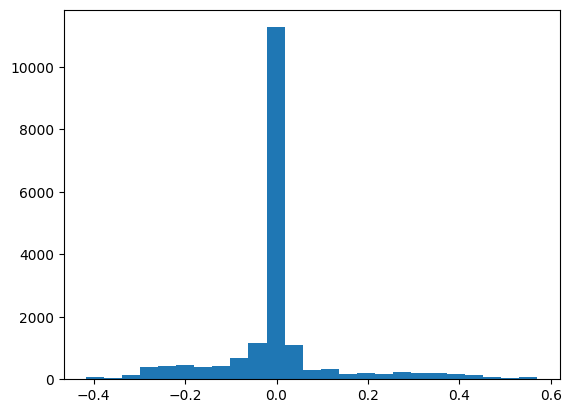

In [ ]:

# Gets dataset
df = pd.read_csv("/home/jrguezg/2025-tfg-jorge-rodriguez/common_utils/datasets/CARLA_manual_dataset_1/data.csv")

# Plots dataset
plt.hist(df["steer"], bins=25)
plt.show()

In [ ]:
# Splits steering column into 25 classes
hist, bins = np.histogram(df["steer"], 25)

indices_to_keep = []

# Loop to run thorugh all columns
# Takes at maximum 600 smaples of each row

for i in range(25):
    bin_indices = df[
        (df["steer"] >= bins[i]) &
        (df["steer"] < bins[i+1])
    ].index.tolist()

    if len(bin_indices) > 600:
        bin_indices = np.random.choice(
            bin_indices,
            600,
            replace=False
        )

    indices_to_keep.extend(bin_indices)

df_balanced = df.loc[indices_to_keep].sample(frac=1).reset_index(drop=True)

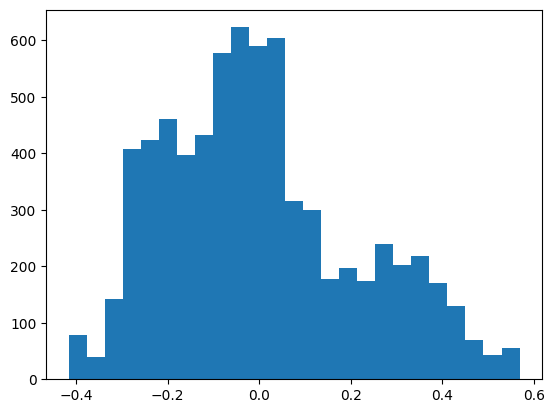

In [ ]:
# Plots results
plt.hist(df_balanced["steer"], bins=25)
plt.show()

### DATASET

In [ ]:
# Dataset class to join Image with steering

class CarlaDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        # Steering data and images names
        self.train_data = csv_file

        # Directory where the images are
        self.dir_img = os.path.expanduser(img_dir)

        # Image transform, it resizes the image and also standarizes it
        self.transform = T.Compose([
            T.Resize((66, 200)),
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        # Gets the image
        img_path = os.path.join(self.dir_img, self.train_data.iloc[idx]["image_name"])

        # Transforms to RGB
        img = Image.open(img_path).convert("RGB")

        # Applies resizing and normalization
        img = self.transform(img)

        # Puts steering as a tensor
        steering = torch.tensor(self.train_data.iloc[idx]["steer"], dtype=torch.float32)

        # Returns image steering pair
        return img, steering

### PILOT NET STRUCTURE

In [ ]:
# Using PilotNet structure

class PilotNet(nn.Module):
    def __init__(self):
        super().__init__()

        '''
        Input planes -> 3@66x200
        Normalized input planes -> 3@66x200

        CONVOLUTIONAL LAYERS

        Layer 1 -> Convolutional feature map 24@31x98
        Layer 2 -> Convolutional feature map 36@14x47
        Layer 3 -> Convolutional feature map 48@5x22
        Layer 4 -> Convolutional feature map 64@3x20
        Layer 5 -> Convolutional feature map 64@1x18

        FULLY CONNECTED LAYERS

        Firstly we flatten
        Layer 1 -> 1164 - 100
        Layer 2 -> 100 - 50
        Layer 3 -> 50 - 10 
        Output layer -> steering

        '''

        self.conv = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ReLU(),

            nn.Conv2d(24, 36, 5, stride=2),
            nn.ReLU(),

            nn.Conv2d(36, 48, 5, stride=2),
            nn.ReLU(),

            nn.Conv2d(48, 64, 3),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
        )
        
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 66, 200)
            n_features = self.conv(dummy).view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_features, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

### TRAINING

In [ ]:
# Splits steering into 25 classes, this is done just to use stratify
n_bins = 25

df_balanced["steer_bin"] = pd.cut(
    df_balanced["steer"],
    bins=n_bins,
    labels=False
)

# Splits dataset into train, validation and test
df_temp, df_train = train_test_split(
    df_balanced, test_size=0.7, random_state=123, stratify=df_balanced["steer_bin"])

df_test, df_val = train_test_split(
    df_temp, test_size=0.5, random_state=123, stratify=df_temp["steer_bin"])

# Removes the column created in each dataset
for d in [df_train, df_val, df_test]:
    d.drop(columns=["steer_bin"], inplace=True)

# Prints all dataset lengths
print(len(df_test))
print(len(df_val))
print(len(df_train))

1060
1060
4948


In [ ]:
 #Creates data loader for train, validation and test

train_df = CarlaDataset(
    csv_file=df_balanced,
    img_dir="/home/jrguezg/2025-tfg-jorge-rodriguez/common_utils/datasets/CARLA_manual_dataset_1"
)
val_df = CarlaDataset(
    csv_file=df_balanced,
    img_dir="/home/jrguezg/2025-tfg-jorge-rodriguez/common_utils/datasets/CARLA_manual_dataset_1"
)
test_df = CarlaDataset(
    csv_file=df_balanced,
    img_dir="/home/jrguezg/2025-tfg-jorge-rodriguez/common_utils/datasets/CARLA_manual_dataset_1"
)

train_loader = DataLoader(train_df, batch_size=32, shuffle=True)
val_loader = DataLoader(val_df, batch_size=32, shuffle=True)
test_loader = DataLoader(test_df, batch_size=32, shuffle=True)

In [ ]:
# Creates model
model = PilotNet()

In [ ]:
# Checks if cuda is available, if not uses cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Move  model to device
model = model.to(device)
print(model)

cuda:0
PilotNet(
  (conv): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=10, bias=True)
    (6): ReLU()
    (7): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [ ]:
# Loss function
criterion = nn.MSELoss()

# Learning rate
lr = 1e-4

# As optimizer Adam is being used
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# TRAINING LOOP

epochs = 10

train_losses = []
valid_losses = []

print("Starting training...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total_train = 0

    for images, steering in train_loader:

        batch_size = steering.size(0)

        images = images.to(device)
        steering = steering.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, steering)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_size
        total_train += batch_size
    
    epoch_train_loss = running_loss / total_train

    model.eval()
    running_valid_loss = 0.0
    total_valid = 0

    with torch.no_grad():
        for images, steering in val_loader:

            batch_size = steering.size(0)

            images = images.to(device)
            steering = steering.to(device).unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, steering)
            
            running_valid_loss += loss.item() * batch_size
            total_valid += batch_size
            
    epoch_valid_loss = running_valid_loss / total_valid

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {epoch_train_loss:.6f} | "
          f"Valid Loss: {epoch_valid_loss:.6f}")

print("\nTraining finished!")

Starting training...

Epoch [1/10] Train Loss: 0.024791 | Valid Loss: 0.019502
Epoch [2/10] Train Loss: 0.015016 | Valid Loss: 0.010311
Epoch [3/10] Train Loss: 0.007631 | Valid Loss: 0.005313
Epoch [4/10] Train Loss: 0.004562 | Valid Loss: 0.003547
Epoch [5/10] Train Loss: 0.003372 | Valid Loss: 0.002797
Epoch [6/10] Train Loss: 0.002630 | Valid Loss: 0.002480
Epoch [7/10] Train Loss: 0.002186 | Valid Loss: 0.001806
Epoch [8/10] Train Loss: 0.001748 | Valid Loss: 0.001790
Epoch [9/10] Train Loss: 0.001532 | Valid Loss: 0.001329
Epoch [10/10] Train Loss: 0.001265 | Valid Loss: 0.001075

Training finished!


 ### SAVING MODEL


In [ ]:
# Saves model into a file
torch.save(model.state_dict(), "pilotnet_weights.pth")